# JP Morgan Virtual Inter Exp Porj Sep 2023

## Task 1: Natual Gas Price Forecast Modelling

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, date
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
from datetime import timedelta
%matplotlib inline

In [ ]:
url = 'https://raw.githubusercontent.com/LeiZhu315/JP_Morgan_Storage_Contract_Pricing_Proj/main/Nat_Gas.csv'
df = pd.read_csv(url)
df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [ ]:
def createFeature(df, label=None):
  df = df.copy()
  df['date'] = pd.to_datetime(df['Dates'], format='%m/%d/%y')
  # df['hour'] = df['date'].dt.hour
  df['month'] = df['date'].dt.month
  df['quarter'] = df['date'].dt.quarter
  df['year'] = df['date'].dt.year
  df['day_of_week'] = df['date'].dt.dayofweek
  df['day_of_year'] = df['date'].dt.dayofyear
  df['week_of_year'] = df['date'].dt.weekofyear

  X = df[['month', 'quarter', 'year', 'day_of_week',
          'day_of_year', 'week_of_year', 'date']]
  if label:
    y = df[label]
    return X, y
  return X

X, y = createFeature(df, label='Prices')
monthly = pd.concat([X, y, df.Dates], axis=1)
monthly.head(5)

<ipython-input-11-a19f6b9067c8>:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week_of_year'] = df['date'].dt.weekofyear


,month,quarter,year,day_of_week,day_of_year,week_of_year,date,Prices,Dates
0,10,4,2020,5,305,44,2020-10-31,10.1,10/31/20
1,11,4,2020,0,335,49,2020-11-30,10.3,11/30/20
2,12,4,2020,3,366,53,2020-12-31,11.0,12/31/20
3,1,1,2021,6,31,4,2021-01-31,10.9,1/31/21
4,2,1,2021,6,59,8,2021-02-28,10.9,2/28/21


### **Exploratory Data Analysis**

#### Visualizing Montly Snapshot of Natural Gas Prices

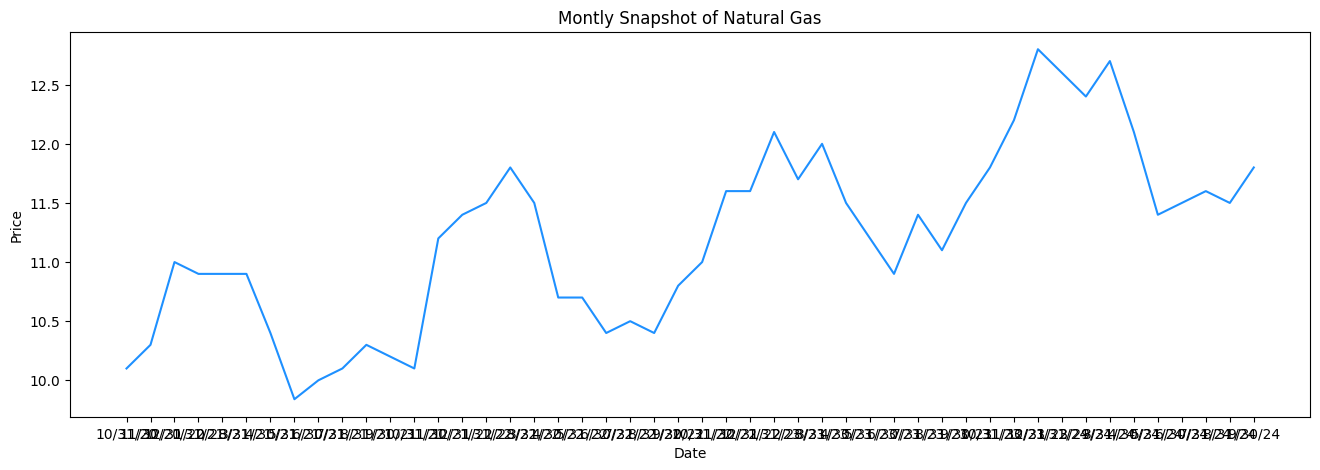

In [ ]:
def plotDf(df, x, y, title='', xlabel='Date', ylabel='Price', dpi=100):
  plt.figure(figsize=(16,5), dpi=dpi)
  plt.plot(x, y, color='dodgerblue')
  plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
  plt.show()

plotDf(monthly, x=monthly.Dates, y=monthly.Prices, title='Montly Snapshot of Natural Gas')

#### Seasonal Plot of Natural Gas Prices

In [ ]:
monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   month         48 non-null     int64         
 1   quarter       48 non-null     int64         
 2   year          48 non-null     int64         
 3   day_of_week   48 non-null     int64         
 4   day_of_year   48 non-null     int64         
 5   week_of_year  48 non-null     int64         
 6   date          48 non-null     datetime64[ns]
 7   Prices        48 non-null     float64       
 8   Dates         48 non-null     object        
 9   str_month     48 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(6), object(2)
memory usage: 3.9+ KB


In [ ]:
monthly['str_month'] = [d.strftime('%b') for d in monthly.date]

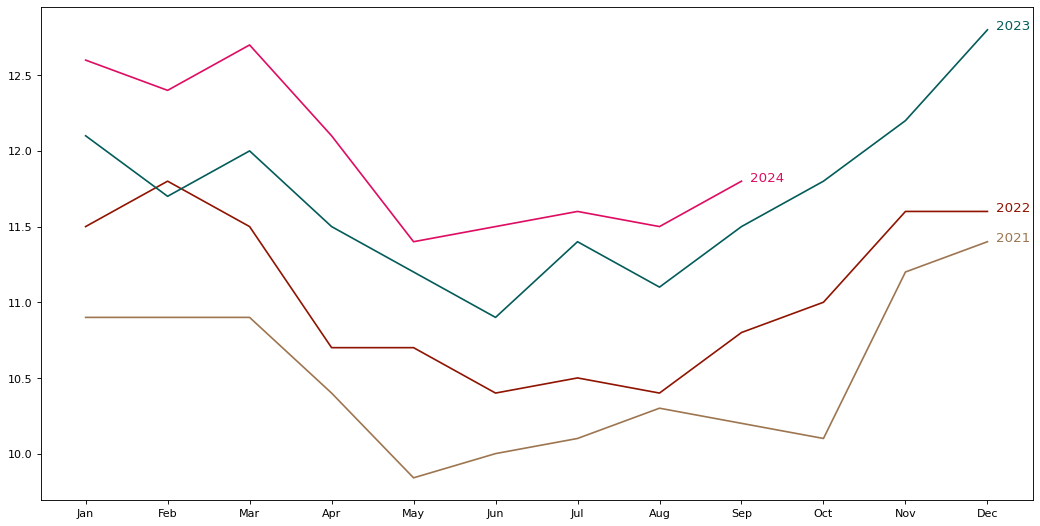

In [ ]:
years = monthly['year'].unique()
np.random.seed(7)
my_colors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

plt.figure(figsize=(16, 8), dpi=80)
for i, y in enumerate(years):
  if i > 0:
    plt.plot('str_month', 'Prices', data=monthly.loc[monthly.year==y, :], color=my_colors[i], label=y)
    plt.text(monthly.loc[monthly.year==y, :].shape[0]-.9,
             monthly.loc[monthly.year==y, 'Prices'][-1:].values[0],
             y, fontsize=12, color=my_colors[i])

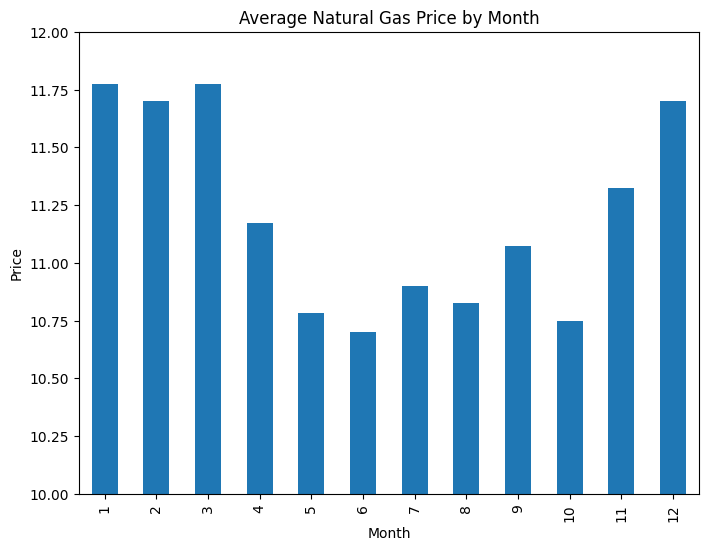

In [ ]:
fig = plt.figure(figsize = (8, 6))
monthly.groupby(['month'])['Prices'].mean().plot.bar(ylim=(10,12))
plt.ylabel('Price')
plt.xlabel('Month')
plt.title('Average Natural Gas Price by Month')
plt.show()

#### Anual Trend

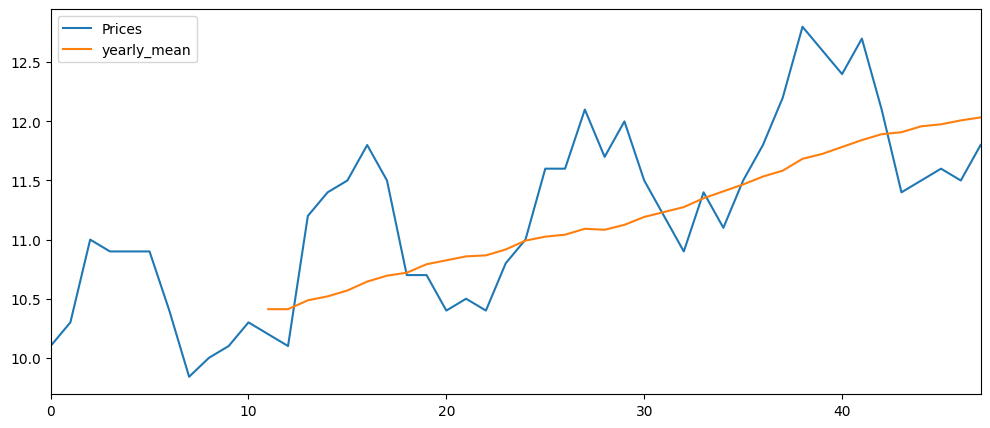

In [ ]:
monthly['yearly_mean'] = monthly['Prices'].rolling(window=12).mean()
monthly[['Prices', 'yearly_mean']].plot(figsize=(12, 5)).autoscale(axis='x', tight=True)

### **Price Forecast Modelling**

In [ ]:
df = pd.read_csv(url, parse_dates=['Dates'], index_col='Dates')
df.reset_index(inplace = True)
split_date = '2023-03-31'
train = df.loc[df.Dates <= split_date].copy()
test = df.loc[df.Dates > split_date].copy()
print(train.shape)
print(test.shape)
train.info()

(30, 2)
(18, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Dates   30 non-null     datetime64[ns]
 1   Prices  30 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 720.0 bytes


In [ ]:
train.rename(columns = {'Dates': 'ds',
                        'Prices': 'y'}).head()

,ds,y
0,2020-10-31,10.1
1,2020-11-30,10.3
2,2020-12-31,11.0
3,2021-01-31,10.9
4,2021-02-28,10.9


In [ ]:
from prophet import Prophet
model = Prophet()
model.fit(train.rename(columns = {'Dates': 'ds',
                        'Prices': 'y'}))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5so4cg0p/ji6ee2jk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5so4cg0p/6brp_9t8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12148', 'data', 'file=/tmp/tmp5so4cg0p/ji6ee2jk.json', 'init=/tmp/tmp5so4cg0p/6brp_9t8.json', 'output', 'file=/tmp/tmp5so4cg0p/prophet_model6crce6em/prophet_model-20230915123548.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:35:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:35:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:

In [ ]:
test_fcst = model.predict(df=test.rename(columns = {'Dates' : 'ds'}))
test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-04-30,11.361876,10.696185,10.968547,11.361450,11.362305,-0.538580,-0.538580,-0.538580,-0.538580,-0.538580,-0.538580,0.0,0.0,0.0,10.823296
1,2023-05-31,11.394183,11.312566,11.586782,11.392886,11.395611,0.061476,0.061476,0.061476,0.061476,0.061476,0.061476,0.0,0.0,0.0,11.455659
2,2023-06-30,11.425449,10.605520,10.864710,11.422824,11.428199,-0.674433,-0.674433,-0.674433,-0.674433,-0.674433,-0.674433,0.0,0.0,0.0,10.751016
3,2023-07-31,11.457756,10.763751,11.020299,11.453648,11.462355,-0.562977,-0.562977,-0.562977,-0.562977,-0.562977,-0.562977,0.0,0.0,0.0,10.894779
4,2023-08-31,11.490064,10.398406,10.647499,11.484398,11.496853,-0.965079,-0.965079,-0.965079,-0.965079,-0.965079,-0.965079,0.0,0.0,0.0,10.524984


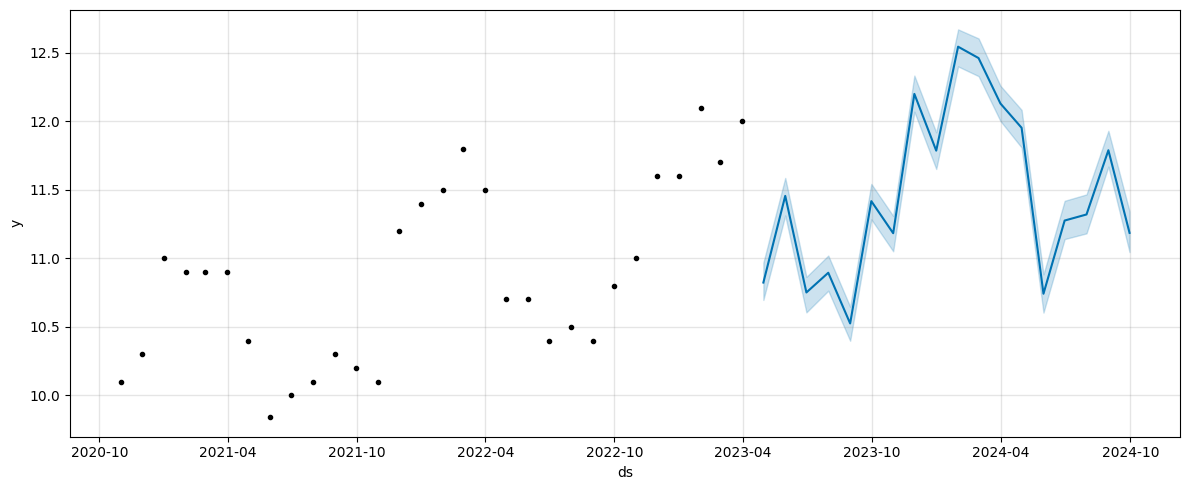

In [ ]:
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(12)
fig = model.plot(test_fcst,
                 ax = ax)
plt.show()

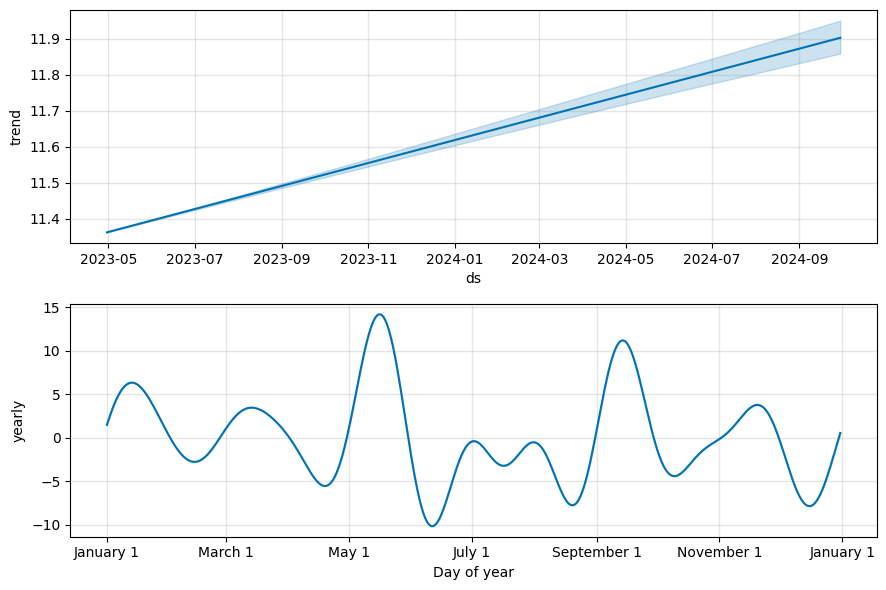

In [ ]:
fig = model.plot_components(test_fcst)

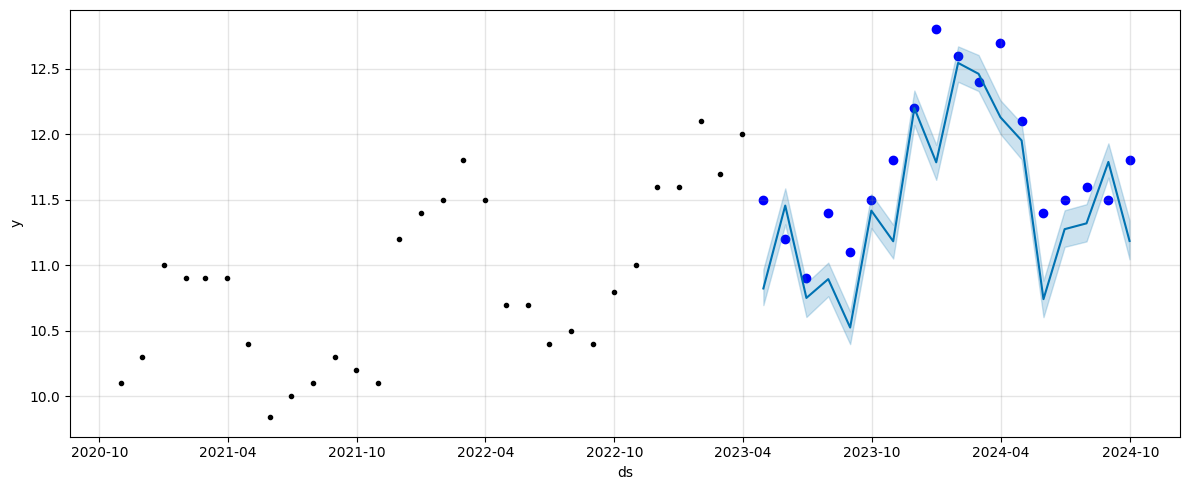

In [ ]:
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(12)
ax.scatter(test.Dates, test['Prices'], color='b')
fig = model.plot(test_fcst, ax=ax)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
mean_squared_error(y_true = test['Prices'],
                   y_pred = test_fcst['yhat'])

0.21800742046392177

In [ ]:
mean_absolute_error(y_true = test['Prices'],
                   y_pred = test_fcst['yhat'])

0.37645171642300274

### **Predicting the Natural Gas Price A Year Ahead**

In [ ]:
model_prophet = Prophet()
model_prophet.fit(df.rename(columns = {'Dates':'ds',
                                       'Prices':'y'}))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5so4cg0p/cid2oj4z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5so4cg0p/sq3u4e9k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37785', 'data', 'file=/tmp/tmp5so4cg0p/cid2oj4z.json', 'init=/tmp/tmp5so4cg0p/sq3u4e9k.json', 'output', 'file=/tmp/tmp5so4cg0p/prophet_modelnioelydk/prophet_model-20230915123613.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
12:36:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:36:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = model_prophet.make_future_dataframe(periods=12, freq='M')
future.tail()

,ds
55,2025-05-31
56,2025-06-30
57,2025-07-31
58,2025-08-31
59,2025-09-30


In [ ]:
forecast = model_prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
55,2025-05-31,11.853798,11.668097,12.036149
56,2025-06-30,11.848575,11.661628,12.040860
57,2025-07-31,11.983327,11.800120,12.179006
58,2025-08-31,11.949657,11.771306,12.122549
59,2025-09-30,12.153211,11.978954,12.353617


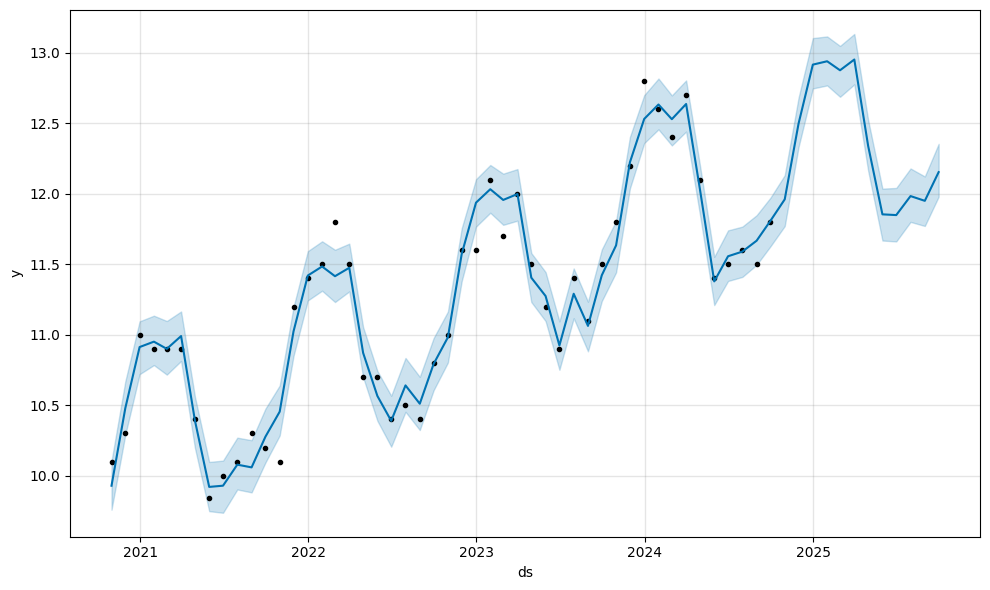

In [ ]:
fig = model_prophet.plot(forecast)

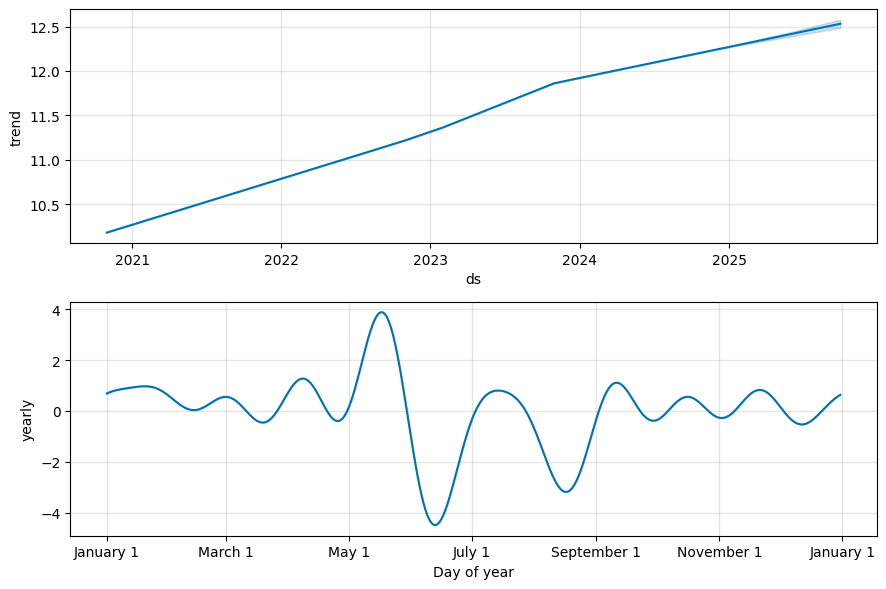

In [ ]:
fig2 = model_prophet.plot_components(forecast)

## Task 2: Natrual Gas Storage Contract Pricing Model

In [ ]:
import math

In [ ]:
def NGStorgateContractVal(Inj_date, Wd_date, IW_rate, max_val, storage_cost_rate):
  purchase_price = model_prophet.predict(Inj_date).yhat
  sell_price = model_prophet.predict(Wd_date).yhat
  print('Purchase Price: ', round(purchase_price, 2))
  print('Sell Price: ', round(sell_price, 2))
  base_value = max(float(sell_price - purchase_price), 0) * max_val * 1e3

  IW_cost = IW_rate * max_val

  duration = (Wd_date - Inj_date) / pd.Timedelta(days=1)
  duration = int(duration.ds)
  storage_cost = storage_cost_rate * (math.ceil(duration / 30))

  cost = IW_cost + storage_cost

  contract_value = max(0, base_value - cost)

  # print(storage_cost, IW_cost, base_value)

  return round(contract_value, 2)


In [ ]:
start_date = '2023-10-01'
end_date = '2024-12-31'
num_dates = 1
dates = pd.date_range(start=start_date, end=end_date, freq='D')
Inj_date = pd.DataFrame(random.sample(list(dates), num_dates), columns=['ds'])
Wd_date = pd.DataFrame(Inj_date['ds'] + timedelta(days = random.randint(30, 180)), columns=['ds'])
# res = model_prophet.predict(Inj_date).yhat
# res2 = model_prophet.predict(Wd_date).yhat
# max(float(res2 - res), 0)
max_val = 1 # unit: million MMBtu
IW_rate = 10 # unit: K $ / million MMBtu
storage_cost_rate = 100 # unit: K $ / month

price = NGStorgateContractVal(Inj_date, Wd_date, IW_rate, max_val, storage_cost_rate)
print('Injection Date: ', Inj_date.ds, '    Withdraw Date: ', Wd_date.ds)
print('Max volum: ', max_val, '    I/W rate: ',IW_rate, 'Storage cost: ', storage_cost_rate )
print('Contract Value in K $: ', price)

Purchase Price:  0    8.42
Name: yhat, dtype: float64
Sell Price:  0    12.86
Name: yhat, dtype: float64
Injection Date:  0   2024-06-07
Name: ds, dtype: datetime64[ns]     Withdraw Date:  0   2024-11-26
Name: ds, dtype: datetime64[ns]
Max volum:  1     I/W rate:  10 Storage cost:  100
Contract Value in K $:  3826.33


In [ ]:
def price_contract(in_dates, in_prices, out_dates, out_prices, rate,
                   storage_cost_rate, total_vol,
                   injection_withdrawal_cost_rate):
  volume = 0
  buy_cost = 0
  cash_in = 0
  last_date = min(min(in_dates), min(out_dates))

  # Ensure dates are in sequence
  all_dates = sorted(set(in_dates + out_dates))

  for i in range(len(all_dates)):
    # processing code for each date
    start_date = all_dates[i]

    if start_date in in_dates:
      # Inject on these dates and sum up cash flows
      if volume <= total_vol - rate:
        volume += rate

        # cost to purchase gas
        buy_cost += rate * in_prices[in_dates.index(start_date)]
        # Injection cost
        injection_cost = rate * injection_withdrawal_cost_rate
        buy_cost += injection_cost
        print('Injected gas on %s at a price of %s'%(start_date, in_prices[in_dates.index(start_date)]))

      else:
        # we do not wnat to inject when rate is greater than total volume minus volume
        print('Injection is not possible on date %s as there is insuffcient space in the storage facility'%start_date)
    elif start_date in out_dates:
      # withdraw on these dates and sum cash flow
      if volume >= rate:
        volume -= rate
        cash_in += rate * out_prices[out_dates.index(start_date)]
        # withdraw cost
        withdraw_cost = rate * injection_withdrawal_cost_rate
        cash_in -= withdraw_cost
        print('Extracted gas on %s at a price of %s'%(start_date, out_prices[out_dates.index(start_date)]))
      else:
        # we cannot withdraw more gas than is actually stored
        print('Extraction is not possible on date %s as there is insufficient volume of gas stored'%start_date)

  store_cost = math.ceil((max(out_dates) - min(in_dates)).days // 30) * storage_cost_rate
  return cash_in - store_cost - buy_cost

In [ ]:
# model testing
from datetime import date
import math
in_dates = [date(2022, 1, 1), date(2022, 2, 1), date(2022, 2, 21), date(2022, 4, 1)] #injection dates
in_prices = [20, 21, 20.5, 22] #prices on the injection days
out_dates = [date(2022, 1, 27), date(2022, 2, 15), date(2022, 3, 20), date(2022, 6, 1)] # extraction dates
out_prices = [23, 19, 21, 25] # prices on the extraction days
rate = 100000 # rate of gas in cubic feet per day
storage_cost_rate = 10000 # total volume in cubic feet
injection_withdrawal_cost_rate = 0.0005  # $/cf
max_storage_volume = 500000 # maximum storage capacity of the storage facility
result = price_contract(in_dates, in_prices, out_dates, out_prices, rate,
                        storage_cost_rate, max_storage_volume,
                        injection_withdrawal_cost_rate)
print(f"The value of the contract is: ${result}")


Injected gas on 2022-01-01 at a price of 20
Extracted gas on 2022-01-27 at a price of 23
Injected gas on 2022-02-01 at a price of 21
Extracted gas on 2022-02-15 at a price of 19
Injected gas on 2022-02-21 at a price of 20.5
Extracted gas on 2022-03-20 at a price of 21
Injected gas on 2022-04-01 at a price of 22
Extracted gas on 2022-06-01 at a price of 25
The value of the contract is: $399600.0
